Speaker Diarization - Exploring Unsupervised Learning

Speaker diarization is the process of partitioning an audio stream into segments according to who is speaking, distinguishing different speakers and organizing speech by individual participants. So basically, **who spoke when?**

**Data used in this assignment:** Data used for the speaker diarization task is a 27 seconds long audio file of a  conversation file between me and a friend. The audio clip was recorded in a noise-free environment with no background noise and no overlaps between the voices of the speakers.

I manually annotated the audio clip and stored the speaker segments with start and end times in a Ground Truth Speaker Segment CSV file. The annotations were rounded to the nearest who number in seconds for convenience.

### Visualisation of Speaker Segments

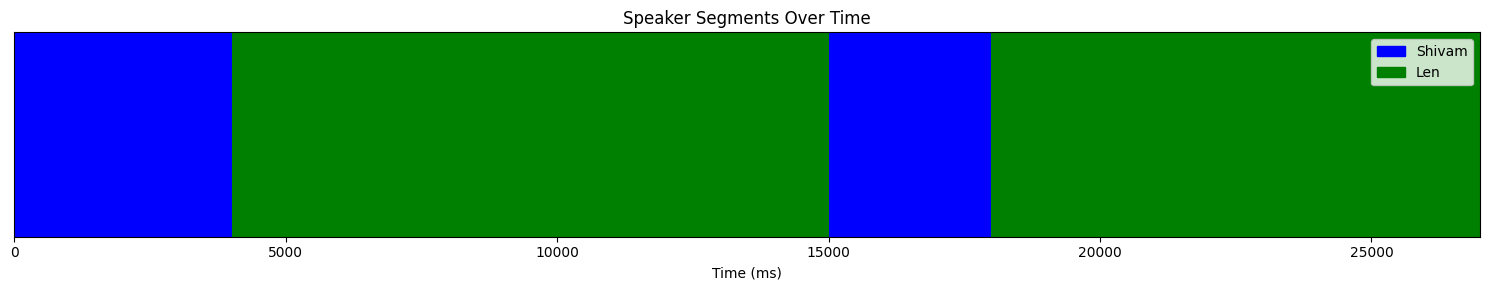

In [ ]:
random.seed(43)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the ground truth annotations from the CSV
ground_truth_csv_path = '/content/TruthAnnotations - Sheet1.csv'  # Replace with your CSV file path
ground_truth = pd.read_csv(ground_truth_csv_path)
ground_truth
# Strip whitespace from column names
ground_truth.columns = ground_truth.columns.str.strip()

# Now we can reliably use the column names
speaker_col = 'Speaker'
start_col = 'Start'
end_col = 'End'

# Plotting the segments
fig, ax = plt.subplots(figsize=(15, 3))  # Adjust the size as needed
ax.set_title('Speaker Segments Over Time')

# Colors for the speakers - you may adjust these if there are more than two speakers
colors = {'Shivam': 'blue', 'Len': 'green'}

# Create a bar for each segment
for index, row in ground_truth.iterrows():
    ax.barh(0.5, row[end_col] - row[start_col], left=row[start_col], height=1, color=colors[row[speaker_col]])

# Set the labels and legend
ax.set_xlabel('Time (ms)')
ax.set_yticks([])
ax.set_xlim(0, ground_truth[end_col].max())
ax.set_ylim(0, 1)
ax.legend(handles=[mpatches.Patch(color=colors[key], label=key) for key in colors], loc='upper right')

plt.tight_layout()
plt.show()


### Goal:
The goal of this assignment is to use Unsupervised learning models to do speaker diarization that matches the ground truth Speaker Segments!

# Experiment 1: Using Gaussian Mixture Model

Gaussian Mixture Models (GMMs) are probabilistic models that assume all data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. They are used to model the presence of subpopulations within an overall population without requiring that an observed dataset should identify the subpopulation to which an individual point belongs.

Components of a GMM:

**Gaussian Distributions:** At its core, a GMM is made up of several Gaussian distributions. Each Gaussian represents a 'cluster' or a group within the data, characterized by its mean (the center of the cluster) and variance (the spread or size of the cluster).
Mixture Weights: Each Gaussian distribution has an associated mixture weight that indicates how prevalent that Gaussian is in the overall mixture. These weights must sum to 1.

**Expectation-Maximization (EM) Algorithm:** GMM parameters are typically estimated using the EM algorithm. The E-step estimates the probabilities that each data point belongs to each cluster, and the M-step updates the parameters of the Gaussians to maximize the likelihood of the data given these probabilities.
In the context of speaker diarization, GMMs are used to model the distribution of features extracted from audio segments. Here’s how they are typically used:

**Feature Extraction:** The first step in speaker diarization is often to extract features from the audio that can discriminate between speakers. MFCCs (Mel-frequency cepstral coefficients) are commonly used for this purpose.
Training GMMs: A GMM is trained for each speaker in the training data. The idea is that the GMM for a speaker will fit well to the MFCCs from that speaker's speech and poorly to others.

**Clustering:** For diarization of a new audio clip, MFCCs are extracted from sliding windows across the audio, and each set of MFCCs is evaluated against the trained GMMs. The set of MFCCs is typically assigned to the speaker whose GMM gives the highest likelihood.
Segmentation: By sliding the window across the audio and assigning segments to speakers, one can effectively segment the entire audio by the speaker.
GMMs for diarization can handle scenarios where there are more complex acoustic patterns since they do not assume a fixed pattern for the audio belonging to each speaker. However, they can struggle with overlapping speech and require careful tuning and sufficient training data for each speaker to be effective.

### Mathematical Walkthrough:

The GMM is defined as:
$$
p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)
$$

Where:
- $p(x)$ is the probability density of the data point $x$
- $K$ is the number of Gaussian distributions in the mixture.
- $\pi_k$ are the mixture weights such that $\sum_{k=1}^{K} \pi_k = 1$ and $\pi_k \geq 0$ for all $k$.
- $\mathcal{N}(x | \mu_k, \Sigma_k)$ is the Gaussian distribution with mean $\mu_k$ and covariance $\Sigma_k$.
- $x$ is a data point in the data space.

The Gaussian distribution for the $k$-th component is defined as:
$$
\mathcal{N}(x | \mu_k, \Sigma_k) = \frac{1}{\sqrt{(2\pi)^D |\Sigma_k|}} \exp\left(-\frac{1}{2}(x-\mu_k)^\top \Sigma_k^{-1} (x-\mu_k)\right)
$$

Expectation-Maximization (EM) Algorithm

The EM algorithm proceeds with the following two steps:

Expectation (E-step)
Calculate the responsibility $\gamma(z_{ik})$ that component $k$ is responsible for data point $x_i$:
$$
\gamma(z_{ik}) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x_i | \mu_j, \Sigma_j)}
$$

Maximization (M-step)
Update the parameters:
$$
\pi_k^{new} = \frac{1}{N} \sum_{i=1}^{N} \gamma(z_{ik})
$$
$$
\mu_k^{new} = \frac{\sum_{i=1}^{N} \gamma(z_{ik}) x_i}{\sum_{i=1}^{N} \gamma(z_{ik})}
$$
$$
\Sigma_k^{new} = \frac{\sum_{i=1}^{N} \gamma(z_{ik}) (x_i - \mu_k^{new})(x_i - \mu_k^{new})^\top}{\sum_{i=1}^{N} \gamma(z_{ik})}
$$

**Loss Function**

The loss function for a GMM is the negative log-likelihood, which is given by:
$$
\mathcal{L}(\theta) = -\sum_{i=1}^{N} \log \left( \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \right)
$$

The goal of the EM algorithm is to minimize this loss function by iteratively updating the parameters $\theta$ until the change in the log-likelihood between iterations is below a certain threshold.

### Python Implementation of GMM model (From Scratch)

In [ ]:
import numpy as np
import librosa
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Gaussian Mixture Model functions
def gaussian_density(feature, mean, covariance):
    size = feature.size
    det_covariance = np.linalg.det(covariance)
    norm_const = 1.0 / (np.power((2*np.pi), float(size)/2) * np.sqrt(det_covariance))
    x_mean = feature - mean
    result = norm_const * np.exp(-0.5 * np.dot(np.dot(x_mean.T, np.linalg.inv(covariance)), x_mean))
    return result

def initialize_parameters_with_kmeans(features, n_components, n_init=10):
    kmeans = KMeans(n_clusters=n_components, random_state=42, n_init=n_init).fit(features)
    means = kmeans.cluster_centers_
    covariances = [np.cov(features[kmeans.labels_ == i].T) + np.eye(features.shape[1]) * 1e-6 for i in range(n_components)]
    weights = np.bincount(kmeans.labels_, minlength=n_components) / len(kmeans.labels_)
    return means, covariances, weights

def gaussian_log_density(feature, mean, covariance):
    size = feature.size
    covariance_inv = np.linalg.inv(covariance)
    det_covariance = np.linalg.det(covariance)
    if det_covariance <= 0:
        return -np.inf
    norm_const = -0.5 * (size * np.log(2 * np.pi) + np.log(det_covariance))
    x_mean = feature - mean
    log_prob = norm_const - 0.5 * np.dot(np.dot(x_mean.T, covariance_inv), x_mean)
    return log_prob

def e_step(features, means, covariances, weights, n_components):
    n_samples = features.shape[0]
    log_responsibilities = np.zeros((n_samples, n_components))
    for i in range(n_samples):
        for j in range(n_components):
            log_responsibilities[i, j] = np.log(weights[j]) + gaussian_log_density(features[i], means[j], covariances[j])
        max_log_responsibility = np.max(log_responsibilities[i, :])
        log_responsibilities[i, :] -= max_log_responsibility
        responsibilities = np.exp(log_responsibilities)
        responsibilities[i, :] /= np.sum(responsibilities[i, :])
    return responsibilities

def m_step(features, responsibilities, n_components, reg_covar=1e-6):
    n_samples, n_features = features.shape
    means = np.zeros((n_components, n_features))
    covariances = [np.zeros((n_features, n_features)) for _ in range(n_components)]
    weights = np.zeros(n_components)

    for j in range(n_components):
        responsibility = responsibilities[:, j]
        total_responsibility = np.sum(responsibility)
        weights[j] = total_responsibility / n_samples
        means[j] = np.dot(responsibility, features) / total_responsibility
        for i in range(n_samples):
            x_mean = features[i] - means[j]
            covariances[j] += responsibility[i] * np.outer(x_mean, x_mean)
        covariances[j] /= total_responsibility
        covariances[j] += np.eye(n_features) * reg_covar

    return means, covariances, weights

def gmm(features, n_components, max_iter):
    means, covariances, weights = initialize_parameters_with_kmeans(features, n_components)
    for _ in range(max_iter):
        responsibilities = e_step(features, means, covariances, weights, n_components)
        means, covariances, weights = m_step(features, responsibilities, n_components)
    return responsibilities, means

# Load and preprocess audio
audio_path = '/content/testwhole.wav'
audio, sr = librosa.load(audio_path, sr=16000)
mfccs = librosa.feature.mfcc(y=audio, sr=sr)
window_size = 100
step_size = 30
hop_length = 512
windows = [np.mean(mfccs[:, i:i+window_size], axis=1) for i in range(0, mfccs.shape[1] - window_size + 1, step_size)]
scaler = StandardScaler()
windows_scaled = scaler.fit_transform(windows)
responsibilities, means = gmm(windows_scaled, n_components=2, max_iter=100)
speaker_labels = np.argmax(responsibilities, axis=1)

# Initialize variables for the loop
current_speaker = speaker_labels[0]
start_time = 0
end_time = window_duration_ms  # Set the initial end_time to the duration of the first window

# Create a list to hold tuples of (start_time, end_time, speaker)
segments = []

# Loop through the labels and create segments
for i, label in enumerate(speaker_labels):
    if label != current_speaker or i == len(speaker_labels) - 1:
        # Append the current segment
        segments.append((start_time, end_time, current_speaker))
        # Update the start and end times for the new segment
        start_time = end_time
        current_speaker = label
    # Update the end time for the next iteration
    end_time = (i * step_size + window_size) * frame_duration_ms

# Print continuous segments
for start, end, speaker in segments:
    print(f"{start:.0f} ms to {end:.0f} ms: Speaker {speaker}")



0 ms to 5120 ms: Speaker 0
5120 ms to 16640 ms: Speaker 1
16640 ms to 20480 ms: Speaker 0
20480 ms to 25280 ms: Speaker 1


### Visualising the Gaussians

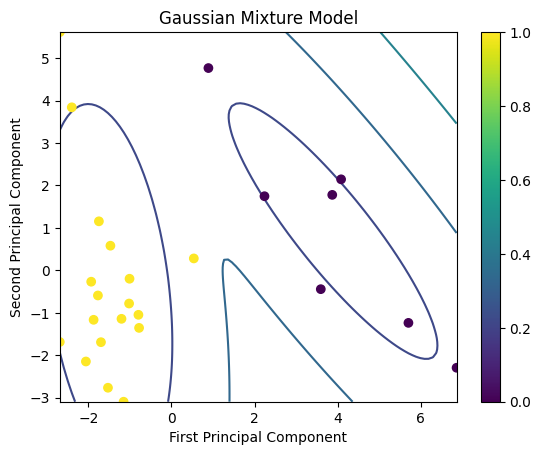

In [ ]:
# Visualization
pca = PCA(n_components=2)
windows_2d = pca.fit_transform(windows_scaled)
gmm_model = GaussianMixture(n_components=2, covariance_type='full', random_state=42).fit(windows_2d)
x = np.linspace(np.min(windows_2d[:, 0]), np.max(windows_2d[:, 0]), 100)
y = np.linspace(np.min(windows_2d[:, 1]), np.max(windows_2d[:, 1]), 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm_model.score_samples(XX)
Z = Z.reshape(X.shape)
plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
plt.scatter(windows_2d[:, 0], windows_2d[:, 1], c=speaker_labels, cmap='viridis', zorder=2)
plt.colorbar()
plt.title('Gaussian Mixture Model')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

### Visualising the Predicted Audio Segments

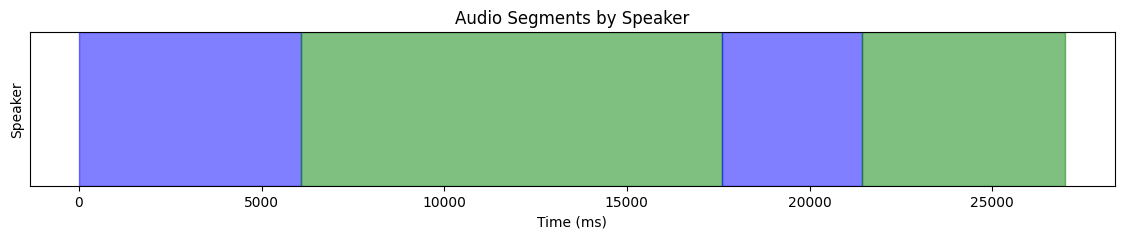

In [ ]:
# Segments visualization
frame_duration_ms = (hop_length / sr) * 1000
window_duration_ms = window_size * frame_duration_ms
current_speaker = speaker_labels[0]
start_time = 0
segments = []
for i, label in enumerate(speaker_labels):
    if label != current_speaker:
        end_time = (i * step_size * frame_duration_ms) + window_duration_ms
        segments.append((start_time, end_time, current_speaker))
        current_speaker = label
        start_time = end_time
final_end_time = len(audio) / sr * 1000
if end_time < final_end_time:
    segments.append((start_time, final_end_time, current_speaker))
plt.figure(figsize=(14, 2))
colors = ['blue', 'green']
for segment in segments:
    start_ms, end_ms, speaker = segment
    plt.axvspan(start_ms, end_ms, color=colors[speaker], alpha=0.5)
plt.title('Audio Segments by Speaker')
plt.xlabel('Time (ms)')
plt.ylabel('Speaker')
plt.yticks([])
plt.show()

### Evaluating the Model (Accuracy)

In [ ]:
import pandas as pd

def load_csv_and_clean_columns(csv_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    # Strip whitespace from the column names
    df.columns = df.columns.str.strip()
    return df

def calculate_overlap(start1, end1, start2, end2):
    # Calculate the overlap between two time segments
    return max(0, min(end1, end2) - max(start1, start2))

def calculate_speaker_accuracy(truth_df, predicted_df, speaker_name):
    # Calculate the total time covered by the ground truth annotations for the given speaker
    speaker_truth = truth_df[truth_df['Speaker'] == speaker_name]
    speaker_total_time = speaker_truth['End'].sum() - speaker_truth['Start'].sum()

    # Initialize the total correct overlap time for the given speaker
    speaker_correct_time = 0

    # Calculate the total overlap time for each ground truth segment for the given speaker
    for _, truth_row in speaker_truth.iterrows():
        overlapping_segments = predicted_df[
            (predicted_df['Start'] < truth_row['End']) & (predicted_df['End'] > truth_row['Start'])
        ]
        for _, pred_row in overlapping_segments.iterrows():
            if truth_row['Speaker'] == pred_row['Speaker']:
                overlap_time = calculate_overlap(truth_row['Start'], truth_row['End'], pred_row['Start'], pred_row['End'])
                speaker_correct_time += overlap_time

    # Calculate accuracy for the given speaker
    speaker_accuracy = speaker_correct_time / speaker_total_time if speaker_total_time > 0 else 0
    return speaker_accuracy

def calculate_accuracy(truth_csv, predicted_csv):
    truth_df = load_csv_and_clean_columns(truth_csv)
    predicted_df = load_csv_and_clean_columns(predicted_csv)

    # Calculate overall accuracy
    overall_accuracy = (calculate_speaker_accuracy(truth_df, predicted_df, 'Shivam') +
                        calculate_speaker_accuracy(truth_df, predicted_df, 'Len')) / 2  # Average accuracy of both speakers

    # Calculate accuracy for each speaker
    len_accuracy = calculate_speaker_accuracy(truth_df, predicted_df, 'Len')
    shivam_accuracy = calculate_speaker_accuracy(truth_df, predicted_df, 'Shivam')

    return overall_accuracy, len_accuracy, shivam_accuracy

truth_csv_path = '/content/TruthAnnotations - Sheet1 (2).csv'
predicted_csv_path = '/content/_Predicted Segments [GMM]  - Sheet1.csv'

overall_accuracy, len_accuracy, shivam_accuracy = calculate_accuracy(truth_csv_path, predicted_csv_path)
print(f"Overall model accuracy: {overall_accuracy:.2f}")
print(f"Accuracy for Len: {len_accuracy:.2f}")
print(f"Accuracy for Shivam: {shivam_accuracy:.2f}")


Overall model accuracy: 0.79
Accuracy for Len: 0.82
Accuracy for Shivam: 0.77


# Experiment 2: Using K-means

K-Means is a popular unsupervised machine learning algorithm that is used for clustering. The goal of K-Means is to partition n data points into k clusters. Each data point belongs to the cluster with the nearest mean, which is known as the cluster's centroid.

The steps of the K-Means algorithm are as follows:

**Initialization:** Select k random points from the dataset as the initial centroids.

**Assignment:** Assign each data point to the nearest centroid. The "nearest" is usually defined using a distance measure like Euclidean distance. After this step, k clusters are formed.

**Update:** Calculate the new centroids as the mean of all points assigned to each cluster.

**Convergence Check:** Repeat steps 2 and 3 until the centroids do not change significantly (within a specified tolerance level) or until a maximum number of iterations is reached.
The result of the K-Means algorithm is a set of k centroids and clusters of data points associated with each centroid.

K-Means can be used in speaker diarization as follows:

**Feature Extraction:** Convert the audio stream into a set of features that can be used for clustering. In your code, Mel-Frequency Cepstral Coefficients (MFCCs) are used. These features effectively capture the properties of the human voice and are commonly used in speech and speaker recognition tasks.

**Clustering:** Use the K-Means algorithm to cluster the MFCC features extracted from the audio stream. Ideally, the algorithm will group together MFCCs that are similar to each other, which should correspond to the same speaker.
Diarization Output: After clustering, the continuous time segments for each cluster (which corresponds to a speaker) are determined. By tracking the changes in cluster assignments over time, you can delineate the segments of audio where different speakers are talking.

The effectiveness of K-Means for speaker diarization relies on the assumption that the feature space (in this case, MFCCs) is well-suited for separating different speakers. If speakers have distinct voices, the algorithm is more likely to distinguish them accurately.

However, K-Means has limitations for diarization. The number of speakers (clusters) must be specified in advance, which may not be known beforehand. Additionally, K-Means assumes that clusters are spherical and equally sized, which may not always be the case with real-world data.

### Mathematical Walkthrough

To understand the K-Means algorithm mathematically, let's define the following terms:

Where:
- $X = \{x_1, x_2, \ldots, x_n\}$ be the set of data points.
- $K$ be the number of clusters.
- $\mu_k$ be the centroid of cluster $k$.
- $C_k$ denote the set of points assigned to cluster $k$.

The algorithm can be described mathematically through the following steps:

**Initialization**:
Choose $K$ initial centroids either randomly from the dataset or based on some heuristic.

**Assignment Step**:
Assign each data point $x_i$ to the cluster $C_k$ with the closest centroid by minimizing the distance between $x_i$ and $\mu_k$, which is typically the Euclidean distance. This can be mathematically represented as:

$$ C_k = \{ x_i : \| x_i - \mu_k \| \leq \| x_i - \mu_j \|, \text{ for all } j \neq k \} $$

**Update Step**:
For each cluster \( C_k \), update its centroid \( \mu_k \) to be the mean of all points \( x_i \) assigned to \( C_k \). Mathematically, the new centroid is calculated as:
$$ \mu_k = \frac{1}{|C_k|} \sum_{x_i \in C_k} x_i $$

**Loss Function (Objective Function)**:
K-Means aims to minimize the within-cluster variance, which is also known as the inertia. The objective function, which K-Means tries to minimize, is given by the sum of squared distances between each point and its corresponding centroid. This is often referred to as the K-Means loss function and is given by:
$$ J = \sum_{k=1}^{K} \sum_{x_i \in C_k} \| x_i - \mu_k \|^2 $$

This function \( J \) is non-convex, and K-Means finds only a local optimum, which is why the initial placement of centroids is important.

**Convergence Criterion**:
The algorithm iteratively performs the assignment and update steps until the centroids do not change significantly, meaning the change in the loss function is less than a defined tolerance level, or a specified number of iterations is reached.


### Python implementation of K-means (from scratch)

In [ ]:
import pandas as pd
import numpy as np
import random
import librosa
random.seed(44)
def k_means(features, k, max_iters=200, tol=1e-4):
    # Step 1: Initialize centroids by randomly selecting k points from the dataset
    centroids = features[np.random.choice(features.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # Step 2: Assign points to the nearest centroid
        distances = np.sqrt(((features - centroids[:, np.newaxis])**2).sum(axis=2))
        closest_centroids = np.argmin(distances, axis=0)

        # Step 3: Update centroids to be the mean of points assigned to each cluster
        new_centroids = np.array([features[closest_centroids == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
            break

        centroids = new_centroids

    return closest_centroids, centroids

# Load audio file
audio_path = '/content/testwhole.wav'
audio, sr = librosa.load(audio_path, sr=16000)  # Use original sampling rate

# Compute MFCCs from the audio signal
mfccs = librosa.feature.mfcc(y=audio, sr=sr)

# Parameters for sliding window
window_size = 40  # Number of frames in each window
step_size = 10   # Number of frames to step for each new window
hop_length = 512  # The default hop length for librosa's mfcc

# Aggregate MFCCs over sliding windows
windows = [
    np.mean(mfccs[:, i:i+window_size], axis=1)
    for i in range(0, mfccs.shape[1] - window_size + 1, step_size)
]

# Scale the windowed MFCC coefficients
windows_scaled = (windows - np.mean(windows, axis=0)) / np.std(windows, axis=0)

# Cluster the aggregated features based on MFCC features
speaker_labels, _ = k_means(np.array(windows_scaled), k=2)  # Adjust based on the expected number of speakers

# Calculate the duration of each window in milliseconds
frame_duration_ms = (hop_length / sr) * 1000
window_duration_ms = window_size * frame_duration_ms

# Initialize variables for the loop
current_speaker = speaker_labels[0]
start_time = 0
end_time = 0

# Create a list to hold tuples of (start_time, end_time, speaker)
segments = []

# Loop through the labels and create segments
for i, label in enumerate(speaker_labels):
    if label != current_speaker:
        # End the current segment at the start of the new one
        segments.append((start_time, end_time, current_speaker))
        current_speaker = label
        start_time = end_time
    end_time = (i * step_size * frame_duration_ms) + window_duration_ms

# Append the last segment
segments.append((start_time, end_time, current_speaker))

# Print continuous segments
for start, end, speaker in segments:
    print(f"{start:.0f} ms to {end:.0f} ms: Speaker {speaker}")


0 ms to 4480 ms: Speaker 0
4480 ms to 16960 ms: Speaker 1
16960 ms to 18560 ms: Speaker 0
18560 ms to 26880 ms: Speaker 1


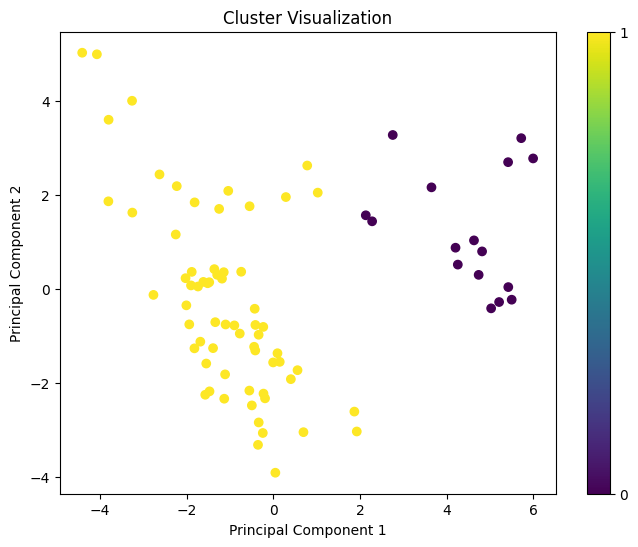

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce the features to 2D for visualization
pca = PCA(n_components=2)
windows_2d = pca.fit_transform(windows_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(windows_2d[:, 0], windows_2d[:, 1], c=speaker_labels, cmap='viridis', marker='o')
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(ticks=[0, 1])
plt.show()


### Visualising the Predicted Audio Segments

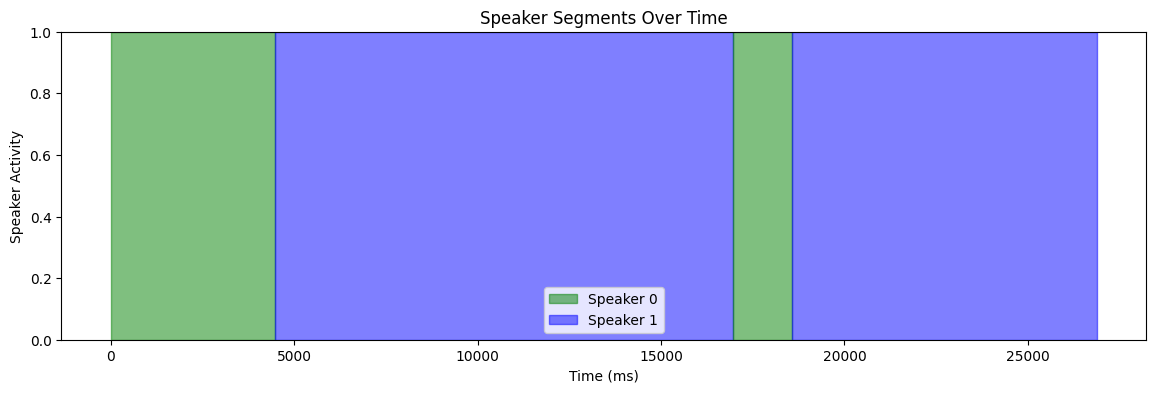

In [ ]:
# Plotting speaker segments
plt.figure(figsize=(14, 4))
colors = ['green','blue']  # Extend this list if more than two speakers
for start, end, speaker in segments:
    plt.axvspan(start, end, color=colors[speaker], alpha=0.5, label=f'Speaker {speaker}')
plt.title('Speaker Segments Over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Speaker Activity')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates in legend
plt.legend(by_label.values(), by_label.keys())
plt.show()

### Evaluating the Model (Accuracy)

In [ ]:
import pandas as pd

def load_csv_and_clean_columns(csv_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    # Strip whitespace from the column names
    df.columns = df.columns.str.strip()
    return df

def calculate_overlap(start1, end1, start2, end2):
    # Calculate the overlap between two time segments
    return max(0, min(end1, end2) - max(start1, start2))

def calculate_speaker_accuracy(truth_df, predicted_df, speaker_name):
    # Calculate the total time covered by the ground truth annotations for the given speaker
    speaker_truth = truth_df[truth_df['Speaker'] == speaker_name]
    speaker_total_time = speaker_truth['End'].sum() - speaker_truth['Start'].sum()

    # Initialize the total correct overlap time for the given speaker
    speaker_correct_time = 0

    # Calculate the total overlap time for each ground truth segment for the given speaker
    for _, truth_row in speaker_truth.iterrows():
        overlapping_segments = predicted_df[
            (predicted_df['Start'] < truth_row['End']) & (predicted_df['End'] > truth_row['Start'])
        ]
        for _, pred_row in overlapping_segments.iterrows():
            if truth_row['Speaker'] == pred_row['Speaker']:
                overlap_time = calculate_overlap(truth_row['Start'], truth_row['End'], pred_row['Start'], pred_row['End'])
                speaker_correct_time += overlap_time

    # Calculate accuracy for the given speaker
    speaker_accuracy = speaker_correct_time / speaker_total_time if speaker_total_time > 0 else 0
    return speaker_accuracy

def calculate_accuracy(truth_csv, predicted_csv):
    truth_df = load_csv_and_clean_columns(truth_csv)
    predicted_df = load_csv_and_clean_columns(predicted_csv)

    # Calculate overall accuracy
    overall_accuracy = (calculate_speaker_accuracy(truth_df, predicted_df, 'Shivam') +
                        calculate_speaker_accuracy(truth_df, predicted_df, 'Len')) / 2  # Average accuracy of both speakers

    # Calculate accuracy for each speaker
    len_accuracy = calculate_speaker_accuracy(truth_df, predicted_df, 'Len')
    shivam_accuracy = calculate_speaker_accuracy(truth_df, predicted_df, 'Shivam')

    return overall_accuracy, len_accuracy, shivam_accuracy

truth_csv_path = '/content/TruthAnnotations - Sheet1 (2).csv'
predicted_csv_path = '/content/Predicted Segments [Kmeans]  - Sheet1.csv'

overall_accuracy, len_accuracy, shivam_accuracy = calculate_accuracy(truth_csv_path, predicted_csv_path)
print(f"Overall model accuracy: {overall_accuracy:.2f}")
print(f"Accuracy for Len: {len_accuracy:.2f}")
print(f"Accuracy for Shivam: {shivam_accuracy:.2f}")


Overall model accuracy: 0.85
Accuracy for Len: 0.93
Accuracy for Shivam: 0.77


# Experiment 2: Using Agglomerative Hierarchical Clustering

Agglomerative Hierarchical Clustering is a type of hierarchical clustering algorithm that builds nested clusters by merging or splitting them successively. This algorithm falls under the category of hierarchical clustering methods, which seek to build a hierarchy of clusters. The agglomerative approach is a "bottom-up" clustering method, starting with each data point as a separate cluster and merging them into successively larger clusters.

Process of Agglomerative Hierarchical Clustering:

**Initialization:**
Each data point is treated as a single cluster. Thus, if there are N data points, we start with N clusters.

**Similarity Computation:**
Compute the proximity matrix, which contains the distances between all pairs of clusters. The distance metric used can be Euclidean, Manhattan, or any other distance measure.

**Cluster Merging:**
Find the pair of clusters that are closest to each other and merge them into a single cluster. This is based on a linkage criterion, such as:

Single-linkage: Distance between the closest members of two clusters.

Complete-linkage: Distance between the farthest members of two clusters.

Average-linkage: Average distance between all members of two clusters.

Ward’s method: Minimize the variance within the clusters.
Update Proximity Matrix:
After merging, the proximity matrix is updated to reflect the distances between the new cluster and the original clusters.

**Repeat:**
Repeat steps 3 and 4 until all data points are clustered into a single cluster that contains all data points, or until a termination condition is met (like a desired number of clusters).
Dendrogram:
A dendrogram is a tree-like diagram that records the sequences of merges and shows the multi-level hierarchy of clusters.
Loss Function:
In agglomerative clustering, there isn't a global objective function like in K-means. Instead, the algorithm makes the locally optimal choice at each step to merge the two most similar clusters. The concept of minimizing variance within clusters (Ward’s method) can be thought of as a local loss minimization, but it is not a loss function in the conventional sense.

**Agglomerative Hierarchical Clustering for Speaker Diarization:**

Speaker diarization involves segmenting audio recordings by speaker identity — determining "who spoke when". Agglomerative hierarchical clustering can be used for speaker diarization in the following way:

Feature Extraction:
Extract features from the audio that can differentiate between speakers. MFCCs are commonly used for this purpose.

Distance Computation:
Compute a measure of dissimilarity between all pairs of feature vectors extracted from the audio. This could be done with a distance metric suitable for the feature space.

Hierarchical Clustering:
Apply agglomerative hierarchical clustering to these features. Begin with each feature vector as a separate cluster and iteratively merge clusters based on the similarity of their features.

Dendrogram Analysis:
Examine the dendrogram to determine the point at which to cut the tree, effectively deciding on the number of speakers.

Segmentation:
Use the clusters formed at the selected cut-point to assign segments of the audio to different speakers.
Agglomerative hierarchical clustering is particularly useful in scenarios where the number of speakers is not known a priori, as the dendrogram can provide insights into the possible number of distinct speakers. The method can also handle cases where speakers might be speaking over each other to some degree, as it does not assume a fixed number of clusters throughout the process.








In [ ]:
import numpy as np
import librosa
from sklearn.cluster import AgglomerativeClustering

# Define a function to perform agglomerative clustering
def agglomerative_clustering(features, n_clusters=2, affinity='euclidean', linkage='ward'):
    # Create the model
    ac = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
    # Fit the model and predict clusters
    labels = ac.fit_predict(features)
    return labels

# Load audio file
audio_path = '/content/testwhole.wav'
audio, sr = librosa.load(audio_path, sr=16000)  # Use the correct sampling rate

# Compute MFCCs from the audio signal
mfccs = librosa.feature.mfcc(y=audio, sr=sr)

# Parameters for sliding window
window_size = 50  # Number of frames in each window
step_size = 10    # Number of frames to step for each new window
hop_length = 512  # The default hop length for librosa's mfcc

# Aggregate MFCCs over sliding windows
windows = [
    np.mean(mfccs[:, i:i+window_size], axis=1)
    for i in range(0, mfccs.shape[1] - window_size + 1, step_size)
]

# Scale the windowed MFCC coefficients
windows_scaled = (windows - np.mean(windows, axis=0)) / np.std(windows, axis=0)


# Predict speaker labels using Agglomerative Clustering
speaker_labels = agglomerative_clustering(np.array(windows_scaled), n_clusters=2)

# Calculate the duration of each window in milliseconds
frame_duration_ms = (hop_length / sr) * 1000
window_duration_ms = window_size * frame_duration_ms

# Initialize the segments list and current speaker
segments = []
current_speaker = speaker_labels[0]
start_time = 0

# Start the loop from the first window
for i, label in enumerate(speaker_labels[1:], start=1):  # Start enumeration from the second label
    if label != current_speaker:
        # End time for the previous speaker segment
        end_time = (i * step_size * frame_duration_ms)
        # Append the segment of the previous speaker
        segments.append((start_time, end_time, current_speaker))
        # Update the current speaker and start time for the new segment
        current_speaker = label
        start_time = end_time

# Ensure the last segment is added
end_time = len(speaker_labels) * step_size * frame_duration_ms
segments.append((start_time, end_time, current_speaker))

# Output the segments
for start, end, speaker in segments:
    print(f"{start:.0f} ms to {end:.0f} ms: Speaker {speaker}")

0 ms to 3200 ms: Speaker 1
3200 ms to 16000 ms: Speaker 0
16000 ms to 17600 ms: Speaker 1
17600 ms to 25600 ms: Speaker 0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


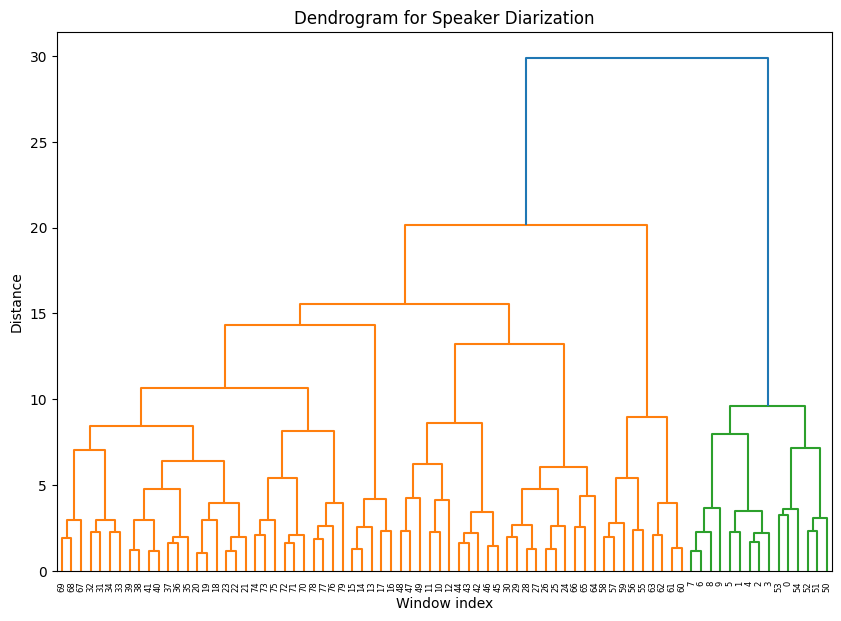

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Use the linkage function to perform hierarchical clustering on the scaled windowed MFCC features
linked = linkage(np.array(windows_scaled), method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Speaker Diarization')
plt.xlabel('Window index')
plt.ylabel('Distance')
plt.show()


### Visualisation of the Predicted Segments

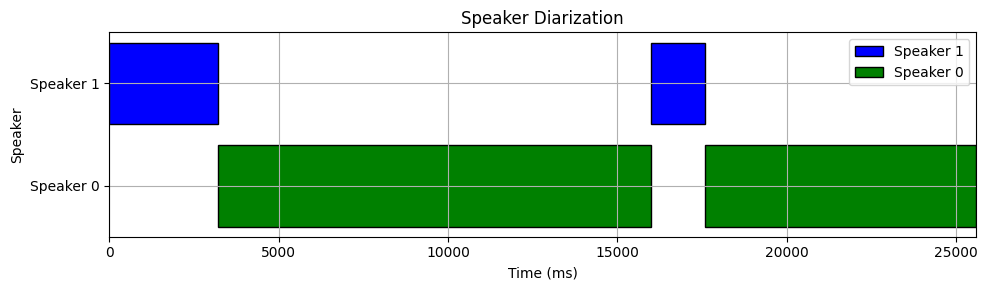

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Visualization
fig, ax = plt.subplots(figsize=(10, 3))

# Set the title and labels
ax.set_title('Speaker Diarization')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Speaker')

# Define the colors for the speakers
colors = ['green', 'blue']

# Create a rectangle for each segment
for start, end, speaker in segments:
    rect = patches.Rectangle((start, speaker - 0.4), end - start, 0.8, edgecolor='black',
                             facecolor=colors[speaker % len(colors)], label=f'Speaker {speaker}')
    ax.add_patch(rect)

# Create the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Set the limits and the grid
ax.set_xlim(0, end)
ax.set_ylim(-0.5, 1.5)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Speaker 0', 'Speaker 1'])
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### Evaluating the Accuracy



In [ ]:
import pandas as pd

def load_csv_and_clean_columns(csv_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    # Strip whitespace from the column names
    df.columns = df.columns.str.strip()
    return df

def calculate_overlap(start1, end1, start2, end2):
    # Calculate the overlap between two time segments
    return max(0, min(end1, end2) - max(start1, start2))

def calculate_speaker_accuracy(truth_df, predicted_df, speaker_name):
    # Calculate the total time covered by the ground truth annotations for the given speaker
    speaker_truth = truth_df[truth_df['Speaker'] == speaker_name]
    speaker_total_time = speaker_truth['End'].sum() - speaker_truth['Start'].sum()

    # Initialize the total correct overlap time for the given speaker
    speaker_correct_time = 0

    # Calculate the total overlap time for each ground truth segment for the given speaker
    for _, truth_row in speaker_truth.iterrows():
        overlapping_segments = predicted_df[
            (predicted_df['Start'] < truth_row['End']) & (predicted_df['End'] > truth_row['Start'])
        ]
        for _, pred_row in overlapping_segments.iterrows():
            if truth_row['Speaker'] == pred_row['Speaker']:
                overlap_time = calculate_overlap(truth_row['Start'], truth_row['End'], pred_row['Start'], pred_row['End'])
                speaker_correct_time += overlap_time

    # Calculate accuracy for the given speaker
    speaker_accuracy = speaker_correct_time / speaker_total_time if speaker_total_time > 0 else 0
    return speaker_accuracy

def calculate_accuracy(truth_csv, predicted_csv):
    truth_df = load_csv_and_clean_columns(truth_csv)
    predicted_df = load_csv_and_clean_columns(predicted_csv)

    # Calculate overall accuracy
    overall_accuracy = (calculate_speaker_accuracy(truth_df, predicted_df, 'Shivam') +
                        calculate_speaker_accuracy(truth_df, predicted_df, 'Len')) / 2  # Average accuracy of both speakers

    # Calculate accuracy for each speaker
    len_accuracy = calculate_speaker_accuracy(truth_df, predicted_df, 'Len')
    shivam_accuracy = calculate_speaker_accuracy(truth_df, predicted_df, 'Shivam')

    return overall_accuracy, len_accuracy, shivam_accuracy

truth_csv_path = '/content/TruthAnnotations - Sheet1 (2).csv'
predicted_csv_path = '/content/Predicted Segments [Kmeans]  - Sheet1.csv'

overall_accuracy, len_accuracy, shivam_accuracy = calculate_accuracy(truth_csv_path, predicted_csv_path)
print(f"Overall model accuracy: {overall_accuracy:.2f}")
print(f"Accuracy for Len: {len_accuracy:.2f}")
print(f"Accuracy for Shivam: {shivam_accuracy:.2f}")


Overall model accuracy: 0.85
Accuracy for Len: 0.93
Accuracy for Shivam: 0.77
